In [44]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as u

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
#d = pickle.load(open("forecaster_params.pickle"))
#d["files"] = "tuned_mueller_pulses_selected"
#d["toa_mode"] = "pipeline"
d = pickle.load(open("fitter_params.pickle"))
F = threebody.Fitter(**d)


In [46]:
res = F.residuals()
print F.goodness_of_fit(F.best_parameters)

203788.582615


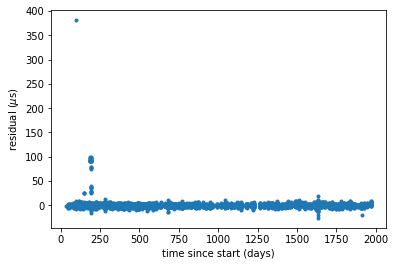

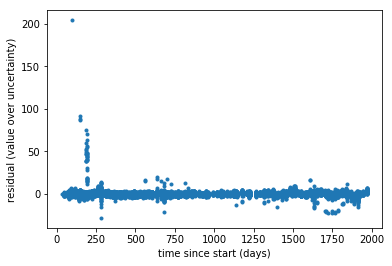

In [47]:
plt.plot(F.mjds, 1e6*res/F.reference_f0, ".")
plt.xlabel("time since start (days)")
plt.ylabel(r"residual ($\mu$s)")
plt.savefig("current-fitter-residuals.pdf", dpi=600, rasterize=True)
plt.figure()
plt.plot(F.mjds, res/F.phase_uncerts, ".")
plt.xlabel("time since start (days)")
plt.ylabel(r"residual (value over uncertainty)")
plt.savefig("current-fitter-z.pdf")


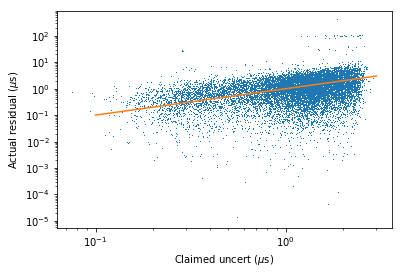

In [48]:
bot = 0.1
top = 3
plt.loglog(1e6*F.phase_uncerts/F.reference_f0, 
           1e6*res/F.reference_f0, ",")
plt.loglog([bot,top],[bot,top])
plt.xlabel(r"Claimed uncert ($\mu$s)")
plt.ylabel(r"Actual residual ($\mu$s)")
plt.savefig("uncert-vs-resid.pdf")

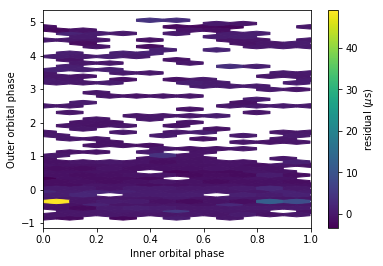

In [50]:
threebody.hexplot(F.best_parameters, F.mjds, 
                  1e6*res/F.reference_f0,
                  gridsize=(10,30))
plt.colorbar(label="residual ($\mu$s)")

## Making TOAs-with-residuals

In [40]:
toa_infos = threebody.read_t2_toas(F.files+".tim")
if len(toa_infos)!=len(res):
    raise ValueError
ixi = np.argsort(F.ix)
for (i,t) in enumerate(toa_infos):
    i_F = ixi[i]
    #print i, i_F, F.phase_uncerts[i_F]
    u_F = 1e6*F.phase_uncerts[i_F]/F.reference_f0
    u_t = t["uncert"]
    if np.abs(u_F - u_t)>1e-3:
        raise ValueError("Uncertainties do not agree: %g and %g"
                         % (u_F, u_t))
    t["flags"]["resid_phase"] = res[i_F]
    t["flags"]["resid_s"] = res[i_F]/F.reference_f0
    t["flags"]["day_bary"] = F.mjds[i_F]
    t["flags"]["uncert_phase"] = F.phase_uncerts[i_F]


In [41]:

zs = [np.abs(t["flags"]["resid_phase"]/t["flags"]["uncert_phase"])
      for t in toa_infos]
ix = np.argsort(zs)[::-1]
i = 0
files = {}
z = np.inf
while(z)>10:
    t = toa_infos[ix[i]]
    f = t["file"]
    o = f.split("/")[2]
    if o not in files:
        z = zs[ix[i]]
        files[o] = [z,
                    1e6*t["flags"]["resid_s"], 
                    t["uncert"], 
                    0]
    files[o][3] += 1        
    i += 1
    
os = []
zss = []
rs = []
us = []
ns = []
for k, v in sorted(files.items()):
    os.append(k)
    zss.append(v[0])
    rs.append(v[1])
    us.append(v[2])
    ns.append(v[3])
    
rows = [[k, v[0], v[1], v[2], v[3]] for (k,v) in sorted(files.items())]
rows.sort(key=lambda r: -r[1])
T = Table(rows=rows,
          names=["Observation", "abs(z)", 
                 "residual", "uncertainty", "n"])
T['residual'].unit = u.us
T['uncertainty'].unit = u.us
T['abs(z)'].format = ".2f"
T['residual'].format = ".3f"
T['uncertainty'].format = ".3f"
T.pprint(max_lines=-1)

   Observation     abs(z) residual uncertainty  n 
                             us         us        
------------------ ------ -------- ----------- ---
  56015.80_AO_1400 204.46  381.349       1.865   1
   56070.64_AO_430  91.36   26.043       0.285   3
56109.30_WSRT_1400  75.41   90.906       1.205  10
56111.17_WSRT_1400  70.71   91.255       1.291  11
56112.44_WSRT_1400  48.12   77.697       1.615   4
  56201.32_AO_1400  29.13  -12.379       0.425   8
56113.15_WSRT_1400  28.08   36.968       1.317  10
   57628.41_AO_430  22.84   -6.900       0.302   2
   57667.34_AO_430  22.55   -7.554       0.335   2
  56599.21_AO_1400  22.55  -13.371       0.593   4
   57643.37_AO_430  21.42   -7.559       0.353   1
   57621.43_AO_430  21.17   -6.380       0.301   1
   57686.26_AO_430  20.89   -6.380       0.305   2
   57705.21_AO_430  20.59   -7.075       0.344   2
   56620.16_AO_430  19.05    5.505       0.289   1
   57551.62_AO_430  17.92   -6.114       0.341   2
   56477.56_AO_430  17.42    5.

In [52]:
anno = dict(resid_phase=res,
            resid_s=res/F.reference_f0,
            day_bary=F.mjds,
            uncert_phase=F.phase_uncerts)
toa_infos_2 = F.annotated_toas(anno)

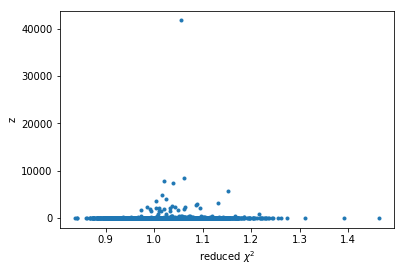

In [59]:
snrs = np.array([float(t["flags"]["snr"]) for t in toa_infos_2])
chi2s = np.array([float(t["flags"]["reduced_chi2"]) 
                  for t in toa_infos_2])
resid_phase = np.array([float(t["flags"]["resid_phase"]) 
                        for t in toa_infos_2])
uncert_phase = np.array([float(t["flags"]["uncert_phase"]) 
                        for t in toa_infos_2])
plt.plot(chi2s, (resid_phase/uncert_phase)**2, ".")
plt.xlabel(r"reduced $\chi^2$")
plt.ylabel("z")

In [57]:
toa_infos_2[0]["flags"]

{'P': '0.00273285578456',
 'band': '1400',
 'bw': '20.0',
 'chan': '5',
 'day_bary': '36.6989459463',
 'max_smearing': '0.04241883288',
 'mode': 'fold',
 'nbin': '512',
 'phase': '0.30476971276',
 'pn': '-4530974479',
 'processing_name': 'tuned2',
 'reduced_chi2': '1.10940790474',
 'resid_phase': '-0.000780444592237',
 'resid_s': '-2.13263398794e-06',
 'snr': '11.1171428287',
 'subint': '0',
 'tel': 'WSRT',
 'toa_name': 'aligned',
 'tsubint': '579.996288',
 'uncert': '0.000803623322186',
 'uncert_phase': '0.00080370190105',
 'uncert_scaled': '0.000846443861987',
 'weighted_frequency': '1429.375'}

## What's in the raw data

In [43]:
gbt_mjds = set()
ao_mjds = set()

for d in ["/data1/GBT/0337+17", "/data1/GBT/0337+17/new"]:
    for f in glob(join(d,"guppi_*")):
        mjd = int(f.split("_")[1])
        gbt_mjds.add(mjd)

a = np.array(sorted(gbt_mjds))
print a
print np.array(zip(a[:-1], np.diff(a), a[1:]))


[55953 55955 55957 55959 55962 55963 55966 55970 55973 55976 55978 55986
 55992 55994 55997 55998 55999 56003 56005 56006 56009 56014 56018 56021
 56028 56031 56034 56036 56039 56041 56044 56047 56050 56053 56056 56060
 56063 56066 56069 56071 56081 56096 56101 56103 56107 56116 56121 56124
 56128 56131 56135 56142 56145 56149 56158 56163 56170 56175 56179 56187
 56197 56203 56207 56214 56223 56234 56236 56241 56246 56274 56276 56283
 56290 56297 56304 56311 56320 56328 56333 56340 56346 56353 56362 56367
 56376 56381 56382 56389 56398 56405 56406 56412 56416 56423 56430 56437
 56444 56458 56465 56471 56479 56487 56494 56500 56506 56515 56523 56527
 56550 56563 56585 56595 56599 56603 56611 56622 56630 56639 56649 56660
 56668 56684 56689 56690 56702 56712 56719 56728 56740 56749 56770 56775
 56787 56789 56799 56821 56830 56841 56849 56856 56863 56870 56877 56914
 56916 56936 56961 56962 56978 57000 57021 57041 57047 57062 57104 57125
 57139 57146 57186 57212 57236 57249 57262 57280 57